paper can be found here http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

In [1]:
!git clone https://github.com/niazwazir/SRCNN.git

Cloning into 'SRCNN'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [2]:
!ls

sample_data  SRCNN


In [3]:
cd SRCNN

/content/SRCNN


In [4]:
!ls

3051crop_weight_200.h5	source.zip
images.zip		Super-Resolution-Image-SRCNN.ipynb


In [5]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/Capture.PNG      
  inflating: images/baboon.bmp       
  inflating: images/baby_GT.bmp      
  inflating: images/barbara.bmp      
  inflating: images/bird_GT.bmp      
  inflating: images/butterfly_GT.bmp  
  inflating: images/coastguard.bmp   
  inflating: images/comic.bmp        
  inflating: images/face.bmp         
  inflating: images/flowers.bmp      
  inflating: images/foreman.bmp      
  inflating: images/head_GT.bmp      
  inflating: images/lenna.bmp        
  inflating: images/monarch.bmp      
  inflating: images/pepper.bmp       
  inflating: images/ppt3.bmp         
  inflating: images/woman_GT.bmp     
  inflating: images/zebra.bmp        


In [6]:
!unzip source.zip

Archive:  source.zip
   creating: source/
  inflating: source/Capture.PNG      
  inflating: source/baboon.bmp       
  inflating: source/baby_GT.bmp      
  inflating: source/barbara.bmp      
  inflating: source/bird_GT.bmp      
  inflating: source/butterfly_GT.bmp  
  inflating: source/coastguard.bmp   
  inflating: source/comic.bmp        
  inflating: source/face.bmp         
  inflating: source/flowers.bmp      
  inflating: source/foreman.bmp      
  inflating: source/head_GT.bmp      
  inflating: source/lenna.bmp        
  inflating: source/monarch.bmp      
  inflating: source/pepper.bmp       
  inflating: source/ppt3.bmp         
  inflating: source/woman_GT.bmp     
  inflating: source/zebra.bmp        


In [7]:
# check package versions
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Using TensorFlow backend.


Python: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Keras: 2.2.4
OpenCV: 3.4.3
NumPy: 1.16.4
Matplotlib: 3.0.3
Scikit-Image: 0.15.0


In [0]:
# import the necessary packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

# python magic function, displays pyplot figures in the notebook
%matplotlib inline

In [0]:
# image quality metrics

# define a function for peak signal-to-noise ratio (PSNR)
# Higer the better
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
# Lower the error more similar to original image
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# ssim stands for Structural Similarity and we are importing it directly from skimage
# It tells how similar two images are. '1' being exactly similar

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


In [0]:
# prepare degraded images by introducing quality distortions via resizing

# 'factor' is the measure to which we will alter the image in 'path'
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int( h / factor )
        new_width = int( w / factor )
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [11]:
# distorting the image
prepare_images('source/', 3)

Saving baby_GT.bmp
Saving lenna.bmp
Saving face.bmp
Saving bird_GT.bmp
Saving monarch.bmp
Saving butterfly_GT.bmp
Saving pepper.bmp
Saving comic.bmp
Saving coastguard.bmp
Saving barbara.bmp
Saving flowers.bmp
Saving baboon.bmp
Saving woman_GT.bmp
Saving zebra.bmp
Saving Capture.PNG
Saving ppt3.bmp
Saving head_GT.bmp
Saving foreman.bmp


In [12]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

baby_GT.bmp
PSNR: 31.69723520103162
MSE: 131.97087478637695
SSIM: 0.8883361032967249

lenna.bmp
PSNR: 29.22505663422242
MSE: 233.18249893188477
SSIM: 0.7874679514772224

face.bmp
PSNR: 28.747257347129583
MSE: 260.3010265700483
SSIM: 0.7185510464651969

bird_GT.bmp
PSNR: 29.79135363470666
MSE: 204.6756847993827
SSIM: 0.9128571831791062

monarch.bmp
PSNR: 27.39136061916819
MSE: 355.68500264485675
SSIM: 0.9074863554787265

butterfly_GT.bmp
PSNR: 22.006520728495104
MSE: 1228.9933776855469
SSIM: 0.797964951530857

pepper.bmp
PSNR: 27.191978538830448
MSE: 372.3949317932129
SSIM: 0.7906274751621787

comic.bmp
PSNR: 21.16826542909264
MSE: 1490.6479002770084
SSIM: 0.7093499981550738

coastguard.bmp
PSNR: 24.189445957446942
MSE: 743.4589942392677
SSIM: 0.6096745582108661

barbara.bmp
PSNR: 23.447393065729266
MSE: 881.9872540509259
SSIM: 0.73065294994638

flowers.bmp
PSNR: 24.88592275321631
MSE: 633.2997845303868
SSIM: 0.7894223069949616

baboon.bmp
PSNR: 20.051808002302312
MSE: 1927.6173
SSIM: 0

In [0]:
# define the SRCNN model

# note that input_shape is (None, None, 1) which means it will work on image with ANY height or weight but needs 
# only one channel! This is also because SRCNN was trained on YCrCb color space in paper (srcnn trained on Y channel). So we have to convert 
# into that channel and feed it.

def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

https://github.com/MarkPrecursor/SRCNN-keras find precomputed weights in 3051crop_weight_200.h5 file

In [0]:
# define necessary image processing functions

# makes image width and height divisible by some scale
def modcrop(img, scale):
    tmpsz = img.shape     # temp size
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale) # ensures dimensions of image are divisible by certain scale
    img = img[0:sz[0], 1:sz[1]]
    return img


# cropping off border size
def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [0]:
# define main prediction function

def predict(image_path):
    
    # load the precomputed srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    # split directory name and path separaytely
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    # Y - Luminance
    # Cr - Red difference
    # Cb - Blue difference
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize between 0 and 1
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0] 
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

W0807 17:45:37.715617 140362601015168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 17:45:37.764401 140362601015168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 17:45:37.772301 140362601015168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 17:45:37.872493 140362601015168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 17:45:37.916891 140362601015168 deprecation_wrappe

Degraded Image: 
PSNR: 22.04861048997752
MSE: 1217.1400877461483
SSIM: 0.7993955895109693

Reconstructed Image: 
PSNR: 22.286128008253062
MSE: 1152.3616977859401
SSIM: 0.8287990482768576



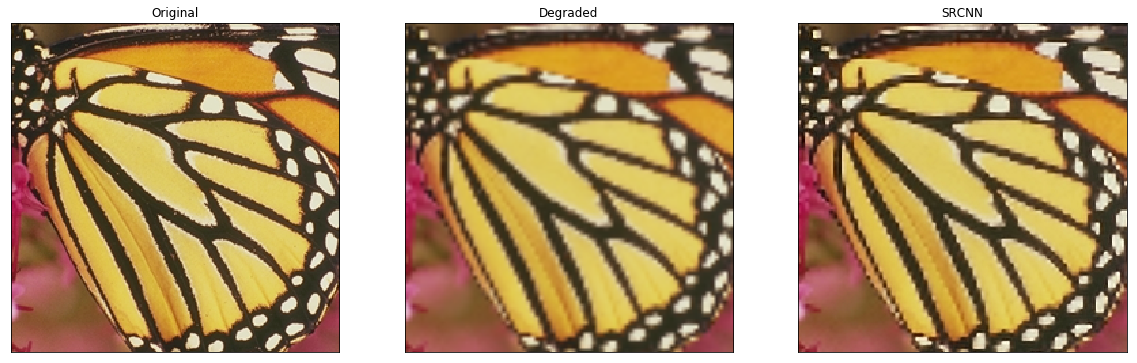

In [16]:
ref, degraded, output, scores = predict('images/butterfly_GT.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots

# rows=1 cols=3 (three images)  
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
# add specific images now

# First subplot - Convert BGR back to RGB as imshow accepts RGB not BGR
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')

# Second subplot
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')

# Third subplot
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])